# Scraping info about current W3C members

In [34]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

import xavy.dataframes as xd
import xavy.text as xt

## Functions

In [2]:
def read_txt(filename):
    """
    Load text from file.
    """
    with open(filename, 'r') as f:
        txt = f.read()
    return txt


def parse_html(filename, item_code):
    """
    Parse an options list in HTML scraped from W3C webpage into
    a DataFrame.
    
    Parameters
    ----------
    filename : str
        Text file containing HTML scraped from W3C webpage.
    item_code : tuple-like
        First element is the text shown when selecting the 
        options; second element is the code used in filtering.
    
    Returns
    -------
    df : DataFrame
        Table with columns given by `item_code` elements and 
        rows from options in `filename`.
    """
    
    # Load HTML:
    html = read_txt(filename)
    soup = BeautifulSoup(html)
    # Get options:
    options = soup.find_all('option')
    # Parse to table:
    dict_list = [{item_code[0]: option.text, item_code[1]: option.attrs['value']} for option in options]
    df = pd.DataFrame(dict_list)
    
    return df

In [14]:
def find_all_class(soup, class_attr):
    """
    Given a Beautiful Soup object `soup`, return all its elements
    whose 'class' attribute is `class_attr` (str) as a list of 
    Beautiful soup objects.    
    """
    elements = soup.find_all(attrs={'class': class_attr})
    return elements

In [15]:
def get_member_info(member_card):
    """
    Given a BeautifulSoup element `member_card` containing the 
    card of a W3C member, extract infos present.
    
    Returns a dict with the entries:
    name, website, description, logo
    """
    
    # Get member name and website:
    anchor = member_card.find('a')
    name   = anchor.text
    link   = anchor.attrs['href']
    
    # Get description, if present:
    par = member_card.find('p')
    if par is not None:
        descr = par.text
    else:
        descr = None
    
    # Get logo, if present:
    img = member_card.find('img')
    if img is not None:
        logo = 'https://www.w3.org' + img.attrs['src']
    else:
        logo = None
        
    return {'name': name, 'website': link, 'description': descr, 'logo': logo}

In [16]:
def scrap_members(template, par):
    """
    Get data from all members with a property given by `template` and 
    `par`.
    
    Parameters
    ----------
    template : str
        A template for an URL with a single parameter that will 
        be specified by `par`.
    par : str
        The parameter for the URL `template`.
        
    Returns
    -------
    df : DataFrame
        A table with the following data for all W3C members that
        fulfill the query provided:
        name, website, description and logo.
    """
    
    # Request:
    response = requests.get(template.format(par))
    if response.status_code != 200:
        raise Exception('Failed request.')

    # Find members:
    soup = BeautifulSoup(response.text)
    member_cards = find_all_class(soup, 'card--member')

    # Parse data about members:
    data = [get_member_info(m) for m in member_cards]
    
    if len(data) == 0:
        return pd.DataFrame(columns=['name', 'website', 'description', 'logo'])
    else:
        df = pd.DataFrame(data)
    
    return df

In [27]:
def scrap_member_slices(slice_df, template):
    """
    Scrap data about W3C members in a 'tomographical' way: 
    Loop over all filtering options and aggregate the results.
    
    Parameters
    ----------
    slice_df : DataFrame
        Table containing the filtering options in a given 
        dimension, which can be country or business ecosystem.
    template : str
        URL template in which the filtering can be applied.
        It must be related to the same dimension specified in
        `slice_df`.
    
    Returns
    -------
    concat_df : DataFrame
        Table with aggregated data from all members collected by 
        filtering by all options in `slice_df`.
    """
    
    # Get number of slices and the dimension on which we are slicing:
    n_slices = len(slice_df)
    dimension = slice_df.columns[0]

    # Loop over slices:
    dfs = []
    for i in range(n_slices):

        # Get common characteristic of slice of members:
        instance = slice_df.iloc[i]
        char = instance[dimension]
        code = instance['code']

        # Scrap data about members:
        df = scrap_members(template, code)
        # Add common characteristics:
        df[dimension] = char
        df[dimension + '_code'] = code

        dfs.append(df)
    
    # Join data from all slices:
    concat_df = pd.concat(dfs, ignore_index=True)
    
    return concat_df

## Parsing list of countries and business ecosystem

In [17]:
country_df = parse_html('../data/raw/scraped/w3c_current-members_2025-04-15_country-list.html', ('country', 'code'))

In [18]:
# Save to CSV:
#country_df.to_csv('../data/cleaned/w3c_current-members_2025-04-15_country-list.csv', index=False)

In [19]:
ecosystem_df = parse_html('../data/raw/scraped/w3c_current-members_2025-04-15_business-ecosystem.html', ('ecosystem', 'code'))
ecosystem_df = ecosystem_df.loc[ecosystem_df['code'].str.len() > 0]

In [20]:
# Save to CSV:
#ecosystem_df.to_csv('../data/cleaned/w3c_current-members_2025-04-15_business-ecosystem.csv', index=False)

## Scraping members' characteristics

In [21]:
# Load selector options:
country_df = pd.read_csv('../data/cleaned/w3c_current-members_2025-04-15_country-list.csv')
ecosystem_df = pd.read_csv('../data/cleaned/w3c_current-members_2025-04-15_business-ecosystem.csv')

# Set URL templates:
template_countries = 'https://www.w3.org/membership/list/?countries[]={:}'
template_ecosystem = 'https://www.w3.org/membership/list/?ecosystem={:}'

### Slicing by country

In [48]:
# Scrap data tomographically, slicing by business country:
country_tomo_df = scrap_member_slices(country_df, template_countries)

In [52]:
# Sanity check:
assert xd.iskeyQ(country_tomo_df[['website']])
assert xd.iskeyQ(country_tomo_df[['name']])

### Slicing by business ecosystem

In [ ]:
# Scrap data tomographically, slicing by business ecosystem:
ecosystem_tomo_df = scrap_member_slices(ecosystem_df, template_ecosystem)

**PS:** The members can belong to none or more than one business ecosystem. Let's massage the data to better represent that. We will use one-hot encoding. 

In [71]:
# One-hot encoding the ecosystems a member belongs to:
ecosystem_tomo_df['onehot_col'] = ecosystem_tomo_df['ecosystem_code'].str.replace('-', '_', regex=False)
ecosystem_pivot_df = ecosystem_tomo_df.pivot_table(values='ecosystem', index='name', columns='onehot_col', aggfunc='count')
ecosystem_pivot_df = ecosystem_pivot_df.fillna(0).astype(int)

### Joining data

In [74]:
full_df = country_tomo_df.join(ecosystem_pivot_df, on='name', how='outer')

In [76]:
# Save CSV:
#full_df.to_csv('../data/processed/w3c_member-organizations_2025-04-15.csv', index=False)

## Explore final data

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np

In [2]:
member_df = pd.read_csv('../data/processed/w3c_member-organizations_2025-04-15.csv')

### Business ecosystems

#### No ecosystem

In [81]:
# Members with no ecosystem:
member_df.loc[member_df[member_df.columns[6:]].isnull().all(axis=1)]

,name,website,description,logo,country,country_code,advertising,data,e_commerce,media,network_communications,publishing,smart_cities,web_of_things
0,Centre For Accessibility Australia,https://www.accessibility.org.au,The Centre for Accessibility Australia (CFA Au...,https://www.w3.org/thumbnails/120/logos/organi...,Australia,AU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Intopia,http://intopia.digital/,NaN,NaN,Australia,AU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Pyx Industries,https://pyx.io,NaN,NaN,Australia,AU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Vision Australia,http://www.visionaustralia.org.au,Vision Australia is a leading national provide...,https://www.w3.org/thumbnails/120/logos/organi...,Australia,AU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Fabasoft,https://www.fabasoft.com/en,Fabasoft is one of the leading software compan...,https://www.w3.org/thumbnails/120/logos/organi...,Austria,AT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,UnitedHealth Group,https://www.unitedhealthgroup.com/,NaN,NaN,United States,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,UsableNet,https://usablenet.com/,NaN,https://www.w3.org/thumbnails/120/logos/organi...,United States,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341,"Verisign, Inc.",http://www.verisigninc.com/,NaN,NaN,United States,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,XRDNA,https://xrdna.io/,NaN,NaN,United States,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that some really do not match any ecosystem (e.g. accessibility consultant companies) while others do but are not allocated (e.g. Zoom).

#### Examples in a given ecosystem

In [86]:
# One specific ecosystem:
eco = 'web_of_things'
member_df.loc[member_df[eco] == 1]

,name,website,description,logo,country,country_code,advertising,data,e_commerce,media,network_communications,publishing,smart_cities,web_of_things
8,WU (Wirschaftsuniversität Wien) - Vienna Unive...,https://www.wu.ac.at/,NaN,https://www.w3.org/thumbnails/120/logos/organi...,Austria,AT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
12,imec,https://www.imec-int.com/,Flanders' research institute imec is devoted t...,https://www.w3.org/thumbnails/120/logos/organi...,Belgium,BE,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
27,360,https://www.360.cn/,NaN,NaN,China,CN,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
28,Alibaba Group,http://www.alibabagroup.com/en/global/home,NaN,NaN,China,CN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
33,ByteDance,https://bytedance.com/,NaN,NaN,China,CN,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
36,China Mobile Communications Corporation,http://www.chinamobileltd.com/en/global/home.php,NaN,NaN,China,CN,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
42,Huawei,http://www.huawei.com,NaN,https://www.w3.org/thumbnails/120/logos/organi...,China,CN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
51,Tencent,http://www.tencent.com,NaN,NaN,China,CN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
55,Agency for Digitisation,https://en.digst.dk/,NaN,NaN,Denmark,DK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65,FIME,https://www.fime.com/,NaN,https://www.w3.org/thumbnails/120/logos/organi...,France,FR,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [87]:
# Google:
member_df.loc[member_df['name'].str.contains('google', case=False)]

,name,website,description,logo,country,country_code,advertising,data,e_commerce,media,network_communications,publishing,smart_cities,web_of_things
264,Google LLC,https://www.google.com/,Google's mission is to organize the world’s in...,https://www.w3.org/thumbnails/120/logos/organi...,United States,US,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
# Meta:
member_df.loc[member_df['name'].str.contains('meta', case=False)]

**Conclusions:** it seems that large companies are involved in almost all ecosystems.

#### Relation between ecosystems

In [3]:
import brass as br

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
marked_ecosystem_df = member_df.set_index('name').iloc[:, 5:].dropna(how='all').astype(int)

In [15]:
features = marked_ecosystem_df.columns
n_features = len(features)

dfs = []
for i in range(0, n_features):
    for j in range(i + 1, n_features):
        a = features[i]
        b = features[j]
        print('{:} x {:}'.format(a, b))
        association = br.AssocEstimator(onehot_trials=marked_ecosystem_df[[a, b]])
        chain_df = association.sample_model()
        sum_df = association.summarize_stats(chain_df, a, b)
        dfs.append(sum_df)
sumstats_df = pd.concat(dfs, ignore_index=True)     

advertising x data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


advertising x e_commerce


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


advertising x media


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


advertising x network_communications


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


advertising x publishing


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.


advertising x smart_cities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


advertising x web_of_things


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.


data x e_commerce


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


data x media


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


data x network_communications


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


data x publishing


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


data x smart_cities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


data x web_of_things


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


e_commerce x media


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.


e_commerce x network_communications


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


e_commerce x publishing


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


e_commerce x smart_cities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


e_commerce x web_of_things


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.


media x network_communications


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


media x publishing


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


media x smart_cities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


media x web_of_things


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


network_communications x publishing


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.


network_communications x smart_cities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


network_communications x web_of_things


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


publishing x smart_cities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


publishing x web_of_things


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


smart_cities x web_of_things


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


In [23]:
bonferroni_p = 0.05 / (n_features * (n_features - 1) / 2)
bonferroni_p

0.0017857142857142859

<Axes: >

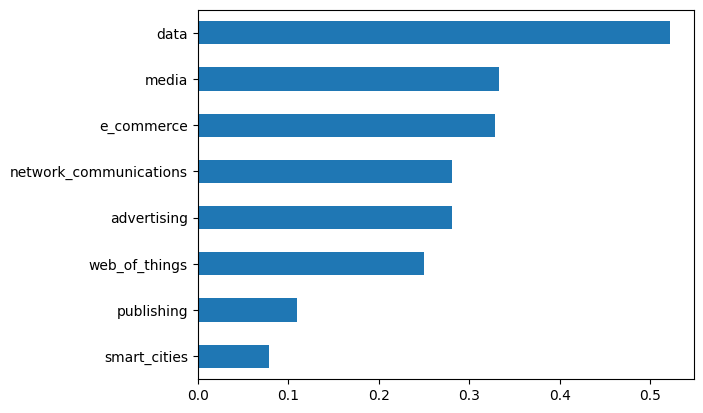

In [29]:
# Most common ecosystems:
marked_ecosystem_df.mean().sort_values(ascending=True).plot(kind='barh')

In [31]:
sumstats_df.sort_values(by=['delta p-value', 'deltaP(A,B)'], ascending=[True, False])

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),"deltaP(A,B)","dev deltaP(A,B)",abs delta nsigma,delta p-value
36,F,media,network_communications,0.335677,0.030698,0.788727,0.050264,0.453050,0.045552,9.945789,0.0000
37,B,network_communications,media,0.283888,0.029618,0.666937,0.052671,0.383049,0.042066,9.105988,0.0000
3,B,e_commerce,advertising,0.331914,0.030740,0.545114,0.061047,0.213200,0.050348,4.234552,0.0000
2,F,advertising,e_commerce,0.284845,0.029142,0.467816,0.056127,0.182971,0.043866,4.171170,0.0000
55,B,web_of_things,smart_cities,0.254171,0.027761,0.550061,0.108246,0.295890,0.103106,2.869752,0.0016
54,F,smart_cities,web_of_things,0.086144,0.018144,0.186528,0.050588,0.100385,0.040219,2.495959,0.0016
6,F,advertising,network_communications,0.284678,0.029182,0.409348,0.060645,0.124670,0.049683,2.509303,0.0035
7,B,network_communications,advertising,0.284578,0.029347,0.409211,0.060880,0.124633,0.049699,2.507746,0.0035
48,F,network_communications,web_of_things,0.284480,0.029286,0.423762,0.063769,0.139282,0.053675,2.594932,0.0037
49,B,web_of_things,network_communications,0.254071,0.029064,0.378398,0.059660,0.124327,0.048272,2.575555,0.0037


# Trash

## Comparing scraps taken a few hours apart

Apparently there was a addition of a new member in the interval of a few hours.

In [54]:
# Load data scraped with the Chrome Web scraper extension:
test_df = pd.read_csv('../data/raw/scraped/w3c_current-members_2025-04-15.csv')

In [67]:
# Data present only in last scrap:
set(country_tomo_df['name']) - set(test_df['member_website'])

{'eBOUND Canada'}

In [66]:
# Data missing in last scrap:
set(test_df['member_website']) - set(country_tomo_df['name'])

set()